In [1]:
import getpass
import os
from langgraph.prebuilt import create_react_agent
import openai 

In [5]:
# check out a list of models
# models = openai.models.list()
# for m in models.data:
#     print(m.id)

In [2]:
# Helper Function
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [3]:
# check for openai API
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")

In [7]:
# https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.chat_agent_executor.create_react_agent
# Create a biologist agent
bio_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[],
    prompt=(
        "You are a biologist.\n\n"
        "INSTRUCTIONS:\n"
        "- You will be given two conflicts. Use your knowledge and examples in biology to propose a solution to solve the conflicts\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="bio_agent",
)

In [11]:
# Example to verify the bio_agent behavior
for chunk in bio_agent.stream(
    {"messages": [{"role": "user", "content": "How to achieve ease of operation while preventing external hamrs from affecting the objects?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: bio_agent

To achieve ease of operation while preventing external harms from affecting the objects, consider the biological example of cellular membranes. Cells maintain internal conditions (homeostasis) and ease of nutrient and waste exchange via selectively permeable membranes. These membranes contain embedded transport proteins that facilitate necessary exchange (ease of operation), while the lipid bilayer acts as a protective barrier against external threats (toxins, pathogens).

Proposed solution:
- Implement a "selective barrier" system around the objects, mimicking cell membrane properties.
- Engineer controlled access points (analogous to transport proteins or channels) that allow for efficient operation or interaction but restrict harmful external factors.
- Use sensor-based mechanisms to detect and neutralize threats, similar to immune proteins that recognize patho

In [12]:
# Create a physicst agent
phy_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[],
    prompt=(
        "You are a physicist.\n\n"
        "INSTRUCTIONS:\n"
        "- You will be given two conflicts. Use your knowledge and examples in physics to propose a solution to solve the conflicts\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="phy_agent",
)

In [14]:
# Example to verify the bio_agent behavior
for chunk in phy_agent.stream(
    {"messages": [{"role": "user", "content": "How to achieve ease of operation while preventing external hamrs from affecting the objects?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: phy_agent

To achieve ease of operation while preventing external harms from affecting objects, consider principles from physics such as shielding and isolation. For example, in the case of sensitive electronic equipment, Faraday cages (grounded enclosures) can shield devices from electromagnetic interference while still allowing user interaction through non-conductive controls or optical interfaces. Similarly, for mechanical systems, vibration isolation platforms (using springs, dampers, or air suspensions) decouple the object from external shocks and vibrations without impeding normal operation. These physics-based solutions maintain usability while safeguarding the object from external disturbances.

Supervisor: Task completed per instructions.




In [15]:
# Create an analyst agent
analyst_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[],
    prompt=(
        "You are an analyst.\n\n"
        "INSTRUCTIONS:\n"
        "- You will be given a problem with two contradicting ideas\n"
        "- Your job is to identify the two contradictions in the problem and abstract them to general ideas\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="analyst_agent",
)

In [16]:
# Example to verify the analyst_agent behavior
for chunk in analyst_agent.stream(
    {"messages": [{"role": "user", "content": "To prevent water erosion of river banks, they can be strengthened with stones. However, water gradually washes sand and soil from under the stones, and the shoreline collapses. What can we do?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: analyst_agent

Contradiction 1 (Abstracted): The solution to prevent erosion (adding stones) is supposed to protect the river bank, but it indirectly causes the same problem (erosion/collapse) it aims to solve.

Contradiction 2 (Abstracted): To stabilize the riverbank, a rigid, immobile structure is needed, but the dynamics of water flow require adaptability and permeability to prevent undercutting and collapse.

Supervisor: The two contradictions have been abstracted and are listed above.




In [18]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("openai:gpt-4.1"),
    agents=[analyst_agent, bio_agent, phy_agent],
    prompt=(
        "You are a supervisor managing three agents and you will be given a problem to solve:\n"
        "- an analyst agent. Assign the problem to this agent which will produce two contradictions\n"
        "- a bio agent. Assign the contradictions to this agent to find a solution from biologist point of view\n"
        "- a physics agent. Assign the contradictions to this agent to find a solution from physics point of view\n"
        "Assign the problem first to the analyst, but you can assign the returning contradictions to the bio agent and physics agent at the same time\n"
        "Summarize the solutions from the bio agent and physics agent"
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()


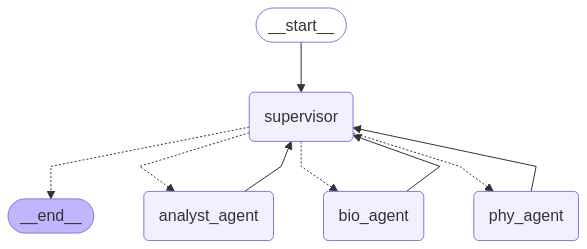

In [19]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [38]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "To prevent water erosion of river banks, they can be strengthened with stones. However, water gradually washes sand and soil from under the stones, and the shoreline collapses. What can we do?",
            }
        ]
    },
):
    pretty_print_messages(chunk)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================ Human Message =================================

To prevent water erosion of river banks, they can be strengthened with stones. However, water gradually washes sand and soil from under the stones, and the shoreline collapses. What can we do?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_analyst_agent (call_kpniD5DpaDnhIsdiByxiUcrl)
 Call ID: call_kpniD5DpaDnhIsdiByxiUcrl
  Args:
================================= Tool Message =================================
Name: transfer_to_analyst_agent

Successfully transferred to analyst_agent


Update from node analyst_agent:


================================ Human Message =================================

To prevent water erosion of river banks, they can be strengthened with stones. However, water gradually washes sand and soil from under the stones, and the shoreline collapses. What can we do?
=========